# Predicción series temporales. Comprobar resultados MLP

En este notebook se llevará a cabo la lectura de los ficheros de resultados de los múltiples modelos que se han entrenado durante el random search, y se comprobará cual proporciona mejores resultados. Para la ejecución aplicando el algoritmo de RandomSearch, se ha hecho uso del programa *random_search_mlp.py*

In [1]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.models import load_model
import seaborn as sns
from sklearn.metrics import accuracy_score

import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt
from paciente import Paciente
from copy import deepcopy
import numpy as np
import utils
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#CF9962", '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']) 
%load_ext autoreload
%autoreload 2

In [2]:
def to_supervised(data, n_input: int, n_out: int, n_margin: int=1):
	"""Convertir los datos a un problema supervisado

	Se transforma el conjunto de datos a un dataset con entradas - salidas.

	Args:
		data (list):  
			Lista con todos los datos de la serie que se quiere transformar.

		n_input (int): 
			Numero de atributos (entradas) de cada muestra a generar.  

		n_out (int): 
			Numero de salidas de cada muestra a generar. 

		n_margin (int): 
			Margen entre una muestra y la siguiente que se genera.

	Returns:
		list: 
			El primer elemento corresponde con las entradas (X) del conjunto
			de datos y el segundo con las salidas (y).
	"""
	X, y = list(), list()
	in_start = 0

	for _ in range(len(data)):
		# Definimos comienzo y fin de la muestra de entrada y de salida
		in_end = in_start + n_input
		out_end = in_end + n_out
		
		# Comprobamos que tenemos datos suficientes
		if out_end <= len(data):
			x_input = data[in_start:in_end]
			X.append(x_input)
			y.append(data[in_end:out_end])

		# Nos movemos tantos pasos como nos digan en n_margin
		in_start += n_margin
	return np.array(X), np.array(y)

In [3]:
def train_test_split(data, train_size=0.8, drop_extremes_percentaje=0):
    """División en conjuntos de entrenamiento y test

    Args:
        data (list):  
            Lista con los valores que se desean dividir en conjuntos de entrenamiento
            y test.

        train_size (float): 
            Porcentaje de datos destinados al conjunto de entrenamiento.  

        drop_extremes_percentaje (float):
            Porcentaje del conjunto de datos que se quiere eliminar de los extremos
            del conjunto de datos. 0.1 indica que se quiere eliminar un 10% del
            inicio de la muestra, y un 10% del final de la muestra.
    Returns:
        list: 
            El primer elemento corresponde con los datos para entrenamiento,
            y el segundo con los datos para test.
    """
    # Elimino los extremos de la muestra.
    if drop_extremes_percentaje > 0 and drop_extremes_percentaje < 0.5: 
        data = data[int(len(data)*drop_extremes_percentaje):-int(len(data)*drop_extremes_percentaje)]

    number_samples_train = int(train_size*len(data))
    return data[:number_samples_train], data[number_samples_train:]

In [4]:
def evaluate_forecasts(actual, predicted):
	"""Calcula el RMSE dada las predicciones y los valores reales

	A partir de las predicciones y los valores reales, se calcula tanto el RMSE
	global del modelo, como el RMSE a cada una de las distancias disponibles
	en la predicción.

	Args:
		actual (list):
			Lista con los valores reales de la salida de las muestras del
			conjunto de datos.

		predicted (list):
			Lista con los valores predecidos de la salida de las muestras del
			conjunto de datos.

	Returns:
		list: 
			El primer elemento representa el RMSE de todo el conjunto de datos, 
			y el segundo elemento de la lista es una lista que representa los
			valores del RMSE en función de la distancia a la predicción. 
	"""
	scores = list()

	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [5]:
def summarize_scores(score, scores):
	"""Realiza el resumen de los resultados del RMSE

	Dado el RMSE global, y el RMSE en función de la distancia a la predicción,
	se representa gráficamente el mismo.

	Args:
		score (int):
			RMSE de todo el conjunto de datos.

		scores (list):
			lista que representa los valores del RMSE en función de la 
			distancia a la predicción.
			
    See Also:
        evaluate_forecasts().
	"""
	s_scores = ', '.join(['%.2f' % s for s in scores])
	print('Root Mean Squared Error: [%.3f]. RMSE in predictions at n step %s' % (score, s_scores))

	# Estableces el numero de ticks en el eje horizontal, así como el nombre de los ticks
	if len(scores) > 1:
		labels = [f"{round((i+1)*time_step, 1)}" for i in range(len(scores))]
		num_ticks = 10
		ticks_step = int(len(labels)/num_ticks)
		x_ticks_pos = list(range(len(labels)))[::ticks_step]
		x_ticks_label = labels[::ticks_step]
		plt.xticks(x_ticks_pos, x_ticks_label)

	plt.plot(scores, marker='o', label='MLP', color="C0")
	plt.ylabel("RMSE")
	plt.xlabel("Seconds")
	plt.title("Evolucion RMSE en función de distancia de valor predicho")
	plt.show()

In [6]:
def preparacion_datos(nombre_fichero, train_size, smooth_seconds, seconds_prior, seconds_prediction, seconds_margin, dataset_dir = "../data/pacientes", variables_significativas = ['SpO2'], drop_extremes_percentaje=0):
    """Función que genera los conjuntos de entrenamiento y test de un paciente.

    A partir del fichero de un paciente, y considerando las características del
    conjunto de datos especificadas en los parámetros, se generan los conjuntos
    de entrenamiento y test del paciente.

    Args:
        nombre_fichero (str):  
            Nombre del fichero donde se ha almacenado el fichero CSV del paciente.

        train_size (float): 
            Porcentaje de datos destinados al conjunto de entrenamiento. 
        
        smooth_seconds (int):  
            Segundos con los que se aplica la ventana deslizante para realizar el
            suavizado de la señal.

        seconds_prediction (int): 
            Numero de segundos posteriores (salidas) de cada muestra a generar. 

        seconds_prior (int): 
            Numero de segundos previos (entradas) de cada muestra a generar.  

        seconds_margin (int): 
            Margen entre una muestra y la siguiente que se genera.
        
        dataset_dir (str):
            Directorio donde se encuentran almacenados la informacion de los pacientes.
        
        variables_significativas (list):
            Lista de variables que se consideran significativas para el paciente.

        drop_extremes_percentaje (float):
            Porcentaje del conjunto de datos que se quiere eliminar de los extremos
            del conjunto de datos. 0.1 indica que se quiere eliminar un 10% del
            inicio de la muestra, y un 10% del final de la muestra.

    Returns:
        list: 
            Lista de listas con todo el conjunto de datos (cada una de las sublistas
            corresponde con uno de los pacientes).
    """
    paciente = Paciente(filename=os.path.join(dataset_dir, nombre_fichero), variables_significativas=variables_significativas)
    paciente.comprobar_validez_dataset()

    paciente.suavizar_seniales(smooth_seconds=smooth_seconds)

    # split into train and test
    train, test = train_test_split(data=paciente.df_smothed["spo2"].values,train_size=train_size, drop_extremes_percentaje=drop_extremes_percentaje)

    # Configuramos el tamaño de entrada y salida de las muestras de la red neuronal
    time_step = paciente.time_step
    n_out = round(seconds_prediction/time_step) if seconds_prediction != 0 else 1
    n_input = round(seconds_prior/time_step)
    n_margin = round(seconds_margin/time_step)

    # Transformamos a serie supervisada
    train_x, train_y = to_supervised(train, n_input, n_out=n_out, n_margin=n_margin)
    test_x, test_y = to_supervised(test, n_input, n_out=n_out, n_margin=n_margin)

    # Almacenamos la lista con el target real
    target_real = test

    return train, test, train_x, train_y, test_x, test_y, target_real, paciente

In [7]:
def extraccion_resultados(n_out, n_input, results_dir, dataset):
    """Extrae resultados de entrenamientos anteriores del MLP.

    A partir de un directorio que contiene previas ejecuciones de entrenamiento del
    perceptrón multicapa, teniendo en cuenta el tamaño de entrada y salidas de las 
    muestras que se utilizaron para entrenar el modelo, evalua los modelos disponibles
    en el directorio para comparar su rendimiento. 

    Args:
        n_out (int): 
            Numero de observaciones posteriores (salidas) de cada muestra a generar. 

        n_input (int): 
            Numero de observaciones previos (entradas) de cada muestra a generar.  

        results_dir (str):
            Directorio donde se encuentran almacenados la informacion de las ejecuciones
            previas del perceptron multicapa.
        
        dataset (list):
            Lista con los datos que se usaron para llevar a cabo el entrenamiento.

    Returns:
        list: 
            Lista que contiene los siguientes elementos: Capas ocultas del modelo, 
            rmse de entrenamiento, rmse de test, batch_size de los datos, n_input, n_out
    """
    # Configuramos el tamaño de entrada y salida de las muestras de la red neuronal
    seconds_margin = 1 # Espacio entre una muestra y la siguiente
    n_margin = round(seconds_margin/time_step)

    # split into train and test
    train, test = train_test_split(data=dataset,train_size=0.8)

    # Transformamos a serie supervisada
    train_x, train_y = to_supervised(train, n_input, n_out=n_out, n_margin=n_margin)
    test_x, test_y = to_supervised(test, n_input, n_out=n_out, n_margin=n_margin)

    # Almacenamos la lista con el target real
    target_real = test

    # Almacenamos en una lista el [nombre, mses_train, mses_test]
    model_stats = []

    for folder in os.listdir(results_dir):
        model_folder = os.path.join(results_dir, folder)
        history_file = os.path.join(model_folder, "history.pickle")

        try: model = load_model(model_folder)
        except: continue
        model_layers = '-'.join([str(layer.input_shape[1]) for layer in model.layers[1:]])
        model_layers = [layer.input_shape[1] for layer in model.layers[1:]]
        print(model_folder)
        batch_size = model_folder.split("_")[-1]
        rmse_train = sqrt(mean_squared_error(model.predict(train_x), train_y))
        rmse_test = sqrt(mean_squared_error(model.predict(test_x), test_y))

        model_stats.append((model_layers, rmse_train, rmse_test, batch_size, n_input, n_out))
        print(f"\tRMSE train: {rmse_train}")
        print(f"\tRMSE test: {rmse_test}")

        # Si existe el history, imprimo en qué epoca se ha llegado al menor mse
        if os.path.exists(history_file):
            with open(history_file, "rb") as handle:
                history = pickle.load(handle)
                epoca_min_loss = history["loss"].index(min(history["loss"])), min(history["loss"]), 
                epoca_min_val_loss = history["val_loss"].index(min(history["val_loss"])), min(history["val_loss"])

                print(f"\tMSE Mejor epoca train:{epoca_min_loss}")
                print(f"\tMSE Mejor epoca test:{epoca_min_val_loss}")
        
    return model_stats

In [8]:
def confusion_matrix(actual, predicted, savefig, accepted_error):
    """Calcula la matriz de confusión dada las predicciones y los valores reales

	A partir de las predicciones y los valores reales, se calcula la matriz de
    confusión (tanto usando valores absolutos como en forma de porcentaje).

    Args:
        actual (list):
            Lista con los valores reales de la salida de las muestras del
            conjunto de datos.

        predicted (list):
            Lista con los valores predecidos de la salida de las muestras del
            conjunto de datos.
        
        savefig (bool):
            Indica si se quiere almacenar el gráfico del resultado en un 
            fichero pdf.
        
        accepted_error (int):
            Indica el número de predicciones adelantadas de error que se tolera.
            Es decir, si se predice que va a haber una desaturación, y no la hay,
            pero si hay una desaturación en las siguientes accepted_error muestras,
            se toma como acierto.

    Returns:
        list: 
            Se devuelven las matrices de confusión (en formato de valor absoluto 
            y en formato de porcentaje). 
    """
    # Calculo la matriz de confusión tradicional
    data = {'y_Actual': actual, 'y_Predicted': predicted}

    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    plt.title("Matriz de confusión")
    sns.heatmap(confusion_matrix, annot=True, cmap=utils.color_map(), fmt='g')
    if savefig: plt.savefig(f"confusion_matriz_normal_{accepted_error}.pdf", transparent=True, bbox_inches = 'tight',pad_inches = 0.025)

    plt.show()

    # Calculo la matriz de confusión con porcentajes
    df_copy = deepcopy(confusion_matrix)
    for col in df_copy.columns:
        df_copy[col] /= sum(df_copy[col])

    df_copy = np.round(df_copy, 2)
    plt.title("Matriz de confusión")

    sns.heatmap(df_copy, annot=True, cmap=utils.color_map(), fmt='g')

    if savefig: plt.savefig(f"confusion_matriz_porcentaje_{accepted_error}.pdf", transparent=True, bbox_inches = 'tight',pad_inches = 0.025)

    plt.show()

    return confusion_matrix, df_copy # Devuelvo las dos matrices de confusion (con porcentajes y con valores absolutos)

In [9]:
def calcular_estadisticas_desaturaciones(actual, predicted, threshold_desaturacion = 4, accepted_error=0, savefig=False):
    """Calcula las matrices de confusión y accuracy

	A partir de las predicciones y los valores reales, se calculan las desaturaciones
    que se han predicho de forma correcta, y se calcula la matriz de confusión 
    (tanto usando valores absolutos como en forma de porcentaje), como el acierto
    global del modelo.


    Args:
        actual (list):
            Lista con los valores reales de la salida de las muestras del
            conjunto de datos.

        predicted (list):
            Lista con los valores predecidos de la salida de las muestras del
            conjunto de datos.
        
        threshold_desaturacion (int):
            Indica la caida en el nivel de saturación que se considera una 
            desaturación.

        savefig (bool):
            Indica si se quiere almacenar el gráfico del resultado en un 
            fichero pdf.
        
        accepted_error (int):
            Indica el número de predicciones adelantadas de error que se tolera.
            Es decir, si se predice que va a haber una desaturación, y no la hay,
            pero si hay una desaturación en las siguientes accepted_error muestras,
            se toma como acierto.

    Returns:
        int: 
            Porcentaje de acierto del modelo.
    
    See Also:
        confusion_matrix().
    """
    # Compruebo si la diferencia entre el mayor y el menor es mayor que el threshold 
    # indicado. De igual forma, hay que comprobar que el máximos se encuentre antes 
    # que el mínimo, para que sea una caida y no subida de saturacion. 
    desaturaciones_real = ((np.max(actual, axis=1) - np.min(actual, axis=1)) *  (np.argmax(actual, axis=1) > np.argmin(actual, axis=1))) > threshold_desaturacion
    desaturaciones_predicted = ((np.max(predicted, axis=1) - np.min(predicted, axis=1)) *  (np.argmax(predicted, axis=1) > np.argmin(predicted, axis=1))) > threshold_desaturacion    
    
    # Miro qué muestras ha predicho correctamente
    posiciones_desaturaciones_real = np.where(desaturaciones_real == True)[0]
    posiciones_desaturaciones_predicted = np.where(desaturaciones_predicted == True)[0]

    # Tengo en cuenta el error aceptado
    current = np.array([])
    for i in range(accepted_error):
        current = np.union1d(current, posiciones_desaturaciones_predicted+i+1)

    new_posiciones_desaturaciones_predicted = np.setdiff1d(current, posiciones_desaturaciones_predicted)

    # Calculo cuales de las nuevas posiciones con el error aceptado habrian sido acierto
    interseccion = np.intersect1d(new_posiciones_desaturaciones_predicted, posiciones_desaturaciones_real).astype(int)

    # Las que habrian sido acierto, las pongo a true
    desaturaciones_predicted[interseccion] = True

    confusion_matrix(desaturaciones_real, desaturaciones_predicted, savefig, accepted_error)

    return accuracy_score(desaturaciones_real, desaturaciones_predicted)

In [10]:
def extract_stats_table(model_stats):
    tamanio_entrada, tamanio_salida, numero_capas_ocultas, capas_ocultas, batch_sizes, mses_train, mses_test, dataframe_data  = [], [], [], [], [], [], [], []

    for i, (model_layers, mse_train, mse_test, batch_size, n_input, n_out) in enumerate(sorted(model_stats, key= lambda x: x[2])):
        tamanio_entrada.append(n_input)
        tamanio_salida.append(n_out)

        numero_capas_ocultas.append(len(model_layers))
        capas_ocultas.append('-'.join([str(i) for i in model_layers]))
        batch_sizes.append(batch_size)
        mses_train.append(mse_train)
        mses_test.append(mses_test)
        dataframe_data.append([n_input, n_out, len(model_layers), '-'.join([str(i) for i in model_layers]), batch_size, mse_train, mse_test])

    df_stats = pd.DataFrame(dataframe_data,columns=["# entradas","# salidas", "# capas ocultas", "Capas ocultas", "batch_size", "RMSE train", "RMSE test"])

    return df_stats

In [11]:
def plot_scatter_mse(model_stats, savefig=False, scale=None):
    plt.figure(figsize=(6, 5))
    colores = [val["color"] for val in list(plt.rcParams['axes.prop_cycle'])]
    legend = {}
    for i, (model_layers, mse_train, mse_test, batch_size, _, _) in enumerate(sorted(model_stats, key= lambda x: x[2])):
        tmp = plt.scatter(i, mse_test,s=100, c=colores[len(model_layers)-1])
        legend[len(model_layers)] = tmp

    plt.legend(list(legend.values()), [f"{capas_ocultas} capas ocultas" for capas_ocultas in legend.keys()])
    plt.xticks([])
    plt.ylabel("RMSE")
    plt.title("RMSE en función de capas ocultas")
    if scale is not None: plt.ylim(scale)

    if savefig: plt.savefig("rmse_vs_capas_scatter.pdf", transparent=True, bbox_inches = 'tight',pad_inches = 0.025)

    plt.show()

## Configuración de variables

En esta sección, se debe indicar la ruta donde se encuentra la información del paciente que se desea utilizar para entrenar el modelo de red neuronal.

In [12]:
dataset_dir = "../data/pacientes"
time_step = 1/3 # Corresponde con el time step entre cada una de las muestras

In [13]:
train, test, train_x, train_y, test_x, test_y, target_real, paciente = preparacion_datos(nombre_fichero="data_5.csv", train_size=0.8, dataset_dir=dataset_dir, smooth_seconds=6, seconds_prior=30, seconds_prediction=0, seconds_margin=1)

In [14]:
# Extraemos un array con todas las muestras del conjunto de datos
datos_total = paciente.df_smothed["spo2"].values

In [15]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((17913, 90), (17913, 1), (4456, 90), (4456, 1))

## Lectura resultados

A continuación, se realizará la lectura de los resultadados de los entrenamientos, calculando en cada uno la raiz del error cuadrático medio sobre los conjuntos de entrenamiento y validación. De igual forma, se comprueba en qué epoca se ha alcanzado la mejor puntuación, para comprobar si existe o no un potencial sobre ajuste del modelo

In [16]:
# Tamaño de entrada 30 segundos
model_30_stats = extraccion_resultados(results_dir="results_mlp/30_input", n_input=round(30/time_step), n_out=1, dataset=datos_total)

results_mlp/30_input/tmp_checkpoint_mlp_1000-750-500-250_64
	RMSE train: 0.08658693924927548
	RMSE test: 0.09911661587931775
	MSE Mejor epoca train:(2496, 0.018852800130844116)
	MSE Mejor epoca test:(2496, 0.009824064560234547)
results_mlp/30_input/tmp_checkpoint_mlp_500-250_32
	RMSE train: 0.0674118773617751
	RMSE test: 0.07629613315867416
	MSE Mejor epoca train:(2458, 0.010554520413279533)
	MSE Mejor epoca test:(2498, 0.005821090191602707)
results_mlp/30_input/tmp_checkpoint_mlp_500-400-300_64
	RMSE train: 0.08380959533996678
	RMSE test: 0.09665872582917365
	MSE Mejor epoca train:(2374, 0.01947423629462719)
	MSE Mejor epoca test:(2496, 0.009342904202640057)
results_mlp/30_input/tmp_checkpoint_mlp_500-500_32
	RMSE train: 0.06718057739325946
	RMSE test: 0.0760138543831135
	MSE Mejor epoca train:(2448, 0.012227719649672508)
	MSE Mejor epoca test:(2447, 0.00577811012044549)
results_mlp/30_input/tmp_checkpoint_mlp_1000-1000_32
	RMSE train: 0.06750732640611437
	RMSE test: 0.076661026253930

In [17]:
# Tamaño de entrada 45 segundos
model_45_stats = extraccion_resultados(results_dir="results_mlp/45_input",  n_input=round(45/time_step), n_out=1, dataset=datos_total)

results_mlp/45_input/tmp_checkpoint_mlp_1500_32
	RMSE train: 0.06055698688081857
	RMSE test: 0.06753443546106792
	MSE Mejor epoca train:(4745, 0.00841096043586731)
	MSE Mejor epoca test:(4931, 0.004560902714729309)
results_mlp/45_input/tmp_checkpoint_mlp_2000_32
	RMSE train: 0.06020580703178825
	RMSE test: 0.0671072147857626
	MSE Mejor epoca train:(4957, 0.008255443535745144)
	MSE Mejor epoca test:(4958, 0.004503381438553333)
results_mlp/45_input/tmp_checkpoint_mlp_1000_32
	RMSE train: 0.06090275646619167
	RMSE test: 0.06805133330389698
	MSE Mejor epoca train:(4979, 0.008478168398141861)
	MSE Mejor epoca test:(4985, 0.0046309842728078365)
results_mlp/45_input/tmp_checkpoint_mlp_4000_32
	RMSE train: 0.0601184456129573
	RMSE test: 0.06687404437522572
	MSE Mejor epoca train:(4907, 0.008192528039216995)
	MSE Mejor epoca test:(4923, 0.004472138825803995)
results_mlp/45_input/tmp_checkpoint_mlp_3000_32
	RMSE train: 0.06006614245243465
	RMSE test: 0.06714501756211778
	MSE Mejor epoca train:(4

In [18]:
# Tamaño de entrada 60 segundos
model_60_stats = extraccion_resultados(results_dir="results_mlp/60_input",n_input=round(60/time_step), n_out=1, dataset=datos_total)

results_mlp/60_input/tmp_checkpoint_mlp_250_32
	RMSE train: 0.07265130504526493
	RMSE test: 0.08339073115482915
	MSE Mejor epoca train:(3163, 0.012733720242977142)
	MSE Mejor epoca test:(3470, 0.006954018492251635)
results_mlp/60_input/tmp_checkpoint_mlp_1000-1000_32
	RMSE train: 0.0729648595057252
	RMSE test: 0.08373649525794197
	MSE Mejor epoca train:(3305, 0.012976429425179958)
	MSE Mejor epoca test:(3494, 0.00701178889721632)
results_mlp/60_input/tmp_checkpoint_mlp_1500_32
	RMSE train: 0.07210087594305288
	RMSE test: 0.0824096566479905
	MSE Mejor epoca train:(3443, 0.012268971651792526)
	MSE Mejor epoca test:(3388, 0.006791353691369295)
results_mlp/60_input/tmp_checkpoint_mlp_2000-1000_64
	RMSE train: 0.08856576455671061
	RMSE test: 0.1031371531534243
	MSE Mejor epoca train:(3371, 0.017524519935250282)
	MSE Mejor epoca test:(3453, 0.010637292638421059)
results_mlp/60_input/tmp_checkpoint_mlp_500-1000_64
	RMSE train: 0.0880948107616455
	RMSE test: 0.10240967663619625
	MSE Mejor epoc

In [19]:
# Tamaño de entrada 45 segundos, salida 10 segundos
model_45_10_stats = extraccion_resultados(results_dir="results_mlp/45_input_10_output",n_input=round(45/paciente.time_step), n_out=round(10/paciente.time_step), dataset=datos_total)

results_mlp/45_input_10_output/tmp_checkpoint_mlp_500-500_32
	RMSE train: 1.70784684715153
	RMSE test: 2.004986280632815
	MSE Mejor epoca train:(4777, 2.7517166137695312)
	MSE Mejor epoca test:(4949, 4.0199689865112305)
results_mlp/45_input_10_output/tmp_checkpoint_mlp_1500_32
	RMSE train: 1.8307685498678863
	RMSE test: 2.2486823152874664
results_mlp/45_input_10_output/tmp_checkpoint_mlp_2000-1000_64
	RMSE train: 1.6758171615098783
	RMSE test: 2.123659845849355
results_mlp/45_input_10_output/tmp_checkpoint_mlp_500-1000_64
	RMSE train: 1.8039171257845894
	RMSE test: 2.0907675047336207
	MSE Mejor epoca train:(4951, 2.4401650428771973)
	MSE Mejor epoca test:(2158, 4.371307849884033)
results_mlp/45_input_10_output/tmp_checkpoint_mlp_2500_32
	RMSE train: 1.8733117019659289
	RMSE test: 2.3051945621138032
results_mlp/45_input_10_output/tmp_checkpoint_mlp_1000-500_64
	RMSE train: 1.6876793113668924
	RMSE test: 2.067127448331737
	MSE Mejor epoca train:(4820, 2.5367820262908936)
	MSE Mejor epoca

In [20]:
# Tamaño de entrada 30 segundos, salida 10 segundos
model_30_10_stats = extraccion_resultados(results_dir="results_mlp/30_input_10_output",n_input=round(30/paciente.time_step), n_out=round(10/paciente.time_step), dataset=datos_total)

results_mlp/30_input_10_output/tmp_checkpoint_mlp_1500_32
	RMSE train: 1.7606206358779972
	RMSE test: 2.1332475508685733
	MSE Mejor epoca train:(4997, 3.2385973930358887)
	MSE Mejor epoca test:(4711, 4.550743579864502)
results_mlp/30_input_10_output/tmp_checkpoint_mlp_2000-1000_64
	RMSE train: 1.6717243883136204
	RMSE test: 1.994339530494977
	MSE Mejor epoca train:(4944, 2.5779941082000732)
	MSE Mejor epoca test:(4152, 3.9773895740509033)
results_mlp/30_input_10_output/tmp_checkpoint_mlp_500-1000_64
	RMSE train: 1.607212329180409
	RMSE test: 2.042076864351163
	MSE Mejor epoca train:(4805, 2.4955265522003174)
	MSE Mejor epoca test:(3722, 4.170078754425049)
results_mlp/30_input_10_output/tmp_checkpoint_mlp_2500_32
	RMSE train: 1.781140032705649
	RMSE test: 2.1647060287603637
	MSE Mejor epoca train:(4860, 3.329261541366577)
	MSE Mejor epoca test:(4729, 4.685952663421631)
results_mlp/30_input_10_output/tmp_checkpoint_mlp_1000-500_64
	RMSE train: 1.6392988927137142
	RMSE test: 1.97593194777

## Comparación resultados de los distintos modelos

En primer lugar, se compararán aquellos modelos que generan únicamente una salida, frente los que generan múltiples salidas. En particular, se va a analizar primero cómo afecta el número de capas ocultas a los resultados.

In [21]:
utils.set_font_size(plt, size=14)

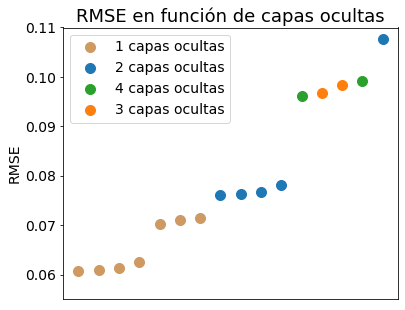

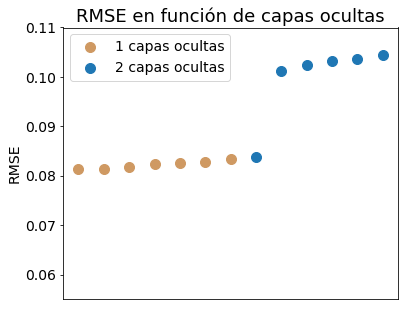

(None, None)

In [22]:
plot_scatter_mse(model_30_stats, savefig=False, scale=[0.055, 0.11]), plot_scatter_mse(model_60_stats, savefig=False, scale=[0.055, 0.11])

Podemos observar en los gráficos anteriores como al generar únicamente una predicción, un menor número de capas nos da mejores resultados.

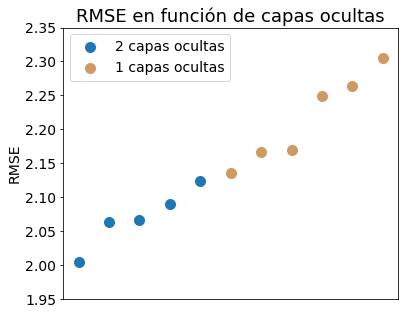

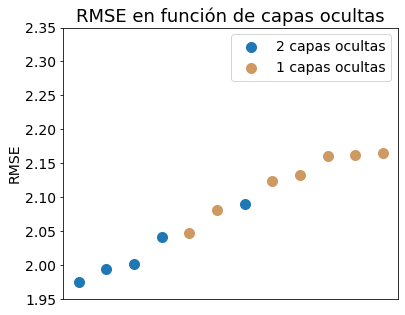

(None, None)

In [23]:
plot_scatter_mse(model_45_10_stats, savefig=True, scale=[1.95, 2.35]), plot_scatter_mse(model_30_10_stats, savefig=True, scale=[1.95, 2.35])

Podemos observar en los gráficos anteriores como al generar múltiples predicciones, un mayor número de capas nos da mejores resultados.

## Resumen de todos los resultados detallado

A continuación se van a mostrar los resultados que se han obtenido con todos los modelos que se han entrenado, en formato de tabla para escoger el mejor modelo, tanto para aquellos modelos que generan una única predicción como aquellos que generan múltiples predicciones.

In [24]:
df_stats = extract_stats_table(model_30_stats + model_60_stats + model_45_stats)
#df_stats = extract_stats_table(model_30_stats + model_60_stats)
df_stats

,# entradas,# salidas,# capas ocultas,Capas ocultas,batch_size,RMSE train,RMSE test
0,90,1,1,1500,32,0.054472,0.060784
1,90,1,1,750,32,0.054732,0.060951
2,90,1,1,500,32,0.054753,0.061251
3,90,1,1,1000,32,0.055870,0.062581
4,135,1,1,4000,32,0.060118,0.066874
5,135,1,1,2000,32,0.060206,0.067107
6,135,1,1,3000,32,0.060066,0.067145
7,135,1,1,1500,32,0.060557,0.067534
8,135,1,1,1000,32,0.060903,0.068051
9,90,1,1,2000,64,0.062425,0.070302


En la tabla superior, podemos ver la comparativa de los modelos que generan únicamente una predicción. Como podemos observar, aquellas con un tamaño de entrada de los últimos 30 segundos son las que proporcionan mejores puntuaciones. De forma adicional, observamos como el número de capas ocultas óptimo es 1, y generalmente un mayor número de neuronas proporciona mejores resultados.

In [25]:
df_stats_multiout = extract_stats_table(model_30_10_stats + model_45_10_stats)
df_stats_multiout

,# entradas,# salidas,# capas ocultas,Capas ocultas,batch_size,RMSE train,RMSE test
0,90,30,2,1000-500,64,1.639299,1.975932
1,90,30,2,2000-1000,64,1.671724,1.994340
2,90,30,2,500-500,64,1.582662,2.002480
3,135,30,2,500-500,32,1.707847,2.004986
4,90,30,2,500-1000,64,1.607212,2.042077
5,90,30,1,750,32,1.687035,2.048266
6,135,30,2,1000-1000,64,1.659030,2.063159
7,135,30,2,1000-500,64,1.687679,2.067127
8,90,30,1,2000,32,1.721331,2.081666
9,90,30,2,1000-1000,64,1.828300,2.090038


En la tabla superior, podemos ver la comparativa de los modelos que generan múltiples predicciones. Como podemos observar, aquellas con un tamaño de entrada de los últimos 30 segundos son las que proporcionan mejores puntuaciones. De forma adicional, observamos como el número de capas ocultas óptimo es 2.

## Cálculo de la matriz de confusión

A continuación, se realiza el cálculo de la matriz de confusión, para ver cuantas desaturaciones se están prediciendo de forma correcta. En este caso, vamos a considerar que una desaturación tiene lugar cuando hay una caída en el nivel de saturación del >= 4%, pero podemos ajustar esto.

Existe otro parámetro, el accepted_error, que nos permite indicar la tolerancia que tienen las predicciones a error. Es decir, si accepted_error = 1, indica que si en una prediccion se predice que hay desaturación y no la hay, pero la siguiente muestra si que es una desaturación, podemos considerarla como una predicción buena. 

In [26]:
threshold_desaturacion = 3
utils.set_font_size(plt, size=15)

### Matriz confusión con modelo múltiples salidas

In [27]:
train, test, train_x, train_y, test_x, test_y, target_real, _ = preparacion_datos(nombre_fichero="data_5.csv", train_size=0.8, smooth_seconds=6, seconds_prior=30, seconds_prediction=10, seconds_margin=1)

In [28]:
model_folder = "results_mlp/30_input_10_output/tmp_checkpoint_mlp_1000-500_64"
model = load_model(model_folder)
predictions = model.predict(test_x)

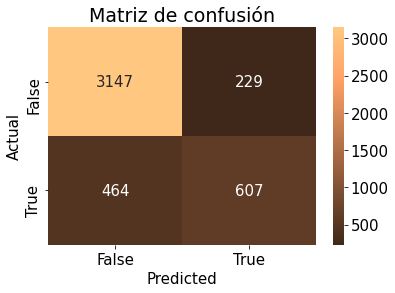

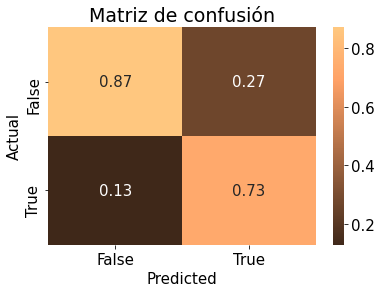

0.8441646053519226

In [29]:
calcular_estadisticas_desaturaciones(actual=test_y, predicted=predictions, threshold_desaturacion = threshold_desaturacion, savefig=False, accepted_error=0)

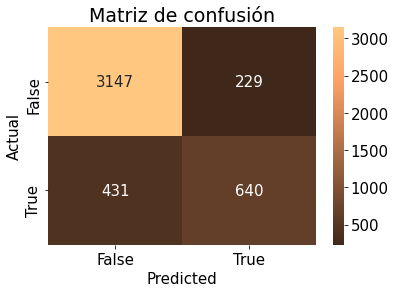

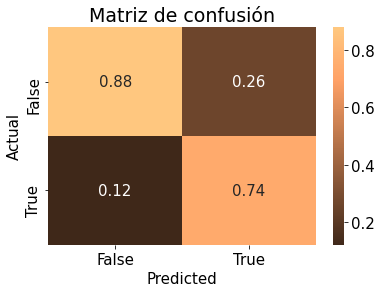

0.8515853384304025

In [30]:
calcular_estadisticas_desaturaciones(actual=test_y, predicted=predictions, threshold_desaturacion = threshold_desaturacion, savefig=False, accepted_error=1)

Podemos observar que hay una elevada tasa de true positives, que incluso se incrementa al introducir el parametro de tolerancia a error.

### Matriz confusión con modelo una salida

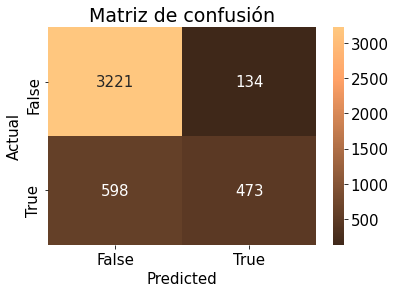

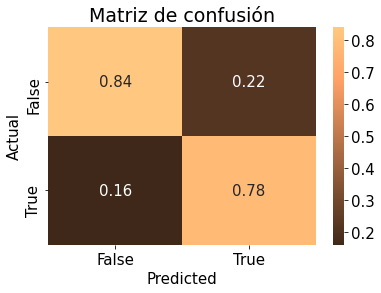

0.8346136466335291

In [31]:
path_modelo = "results_mlp/30_input/tmp_checkpoint_mlp_1500_32"
with open(os.path.join(path_modelo, "predicted_vs_real.pickle"), "rb") as handle:
    forward_predicted_list, forward_real_list = pickle.load(handle)

calcular_estadisticas_desaturaciones(actual=forward_real_list, predicted=forward_predicted_list, threshold_desaturacion = threshold_desaturacion, accepted_error=0, savefig=True)

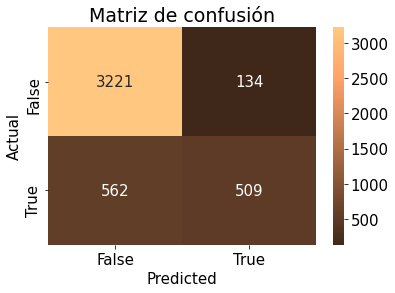

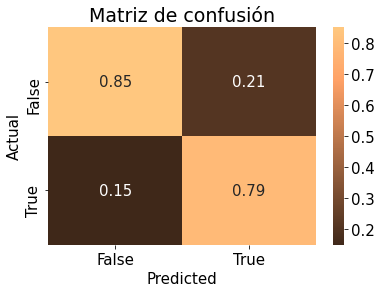

0.842747401717126

In [32]:
path_modelo = "results_mlp/30_input/tmp_checkpoint_mlp_1500_32"
with open(os.path.join(path_modelo, "predicted_vs_real.pickle"), "rb") as handle:
    forward_predicted_list, forward_real_list = pickle.load(handle)

calcular_estadisticas_desaturaciones(actual=forward_real_list, predicted=forward_predicted_list, threshold_desaturacion = threshold_desaturacion, accepted_error=1, savefig=True)

Como podemos observar, se han obtenido mejores resultados al utilizar el modelo de una única salida que al utilizar el modelo que generaba múltiples salidas.

Hay que destacar que dicho modelo se está entrenando y evaluando sobre la señal suavizada, por lo que conviene ver el funcionamiento al eliminar dicho suavizado.

## Cálculo de la matriz de confusión utilizando la serie sin suavizar

In [33]:
train, test, train_x, train_y, test_x, test_y, target_real, _ = preparacion_datos(nombre_fichero="data_5.csv", train_size=0.8, smooth_seconds=0, seconds_prior=30, seconds_prediction=10, seconds_margin=1)

In [34]:
model_folder = "results_mlp/30_input_10_output/tmp_checkpoint_mlp_1000-500_64"
model = load_model(model_folder)
predictions = model.predict(test_x)

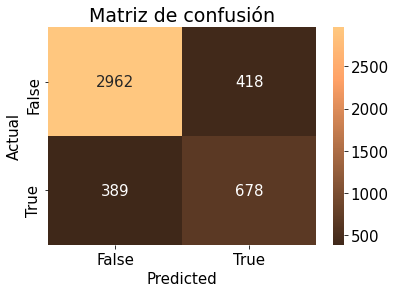

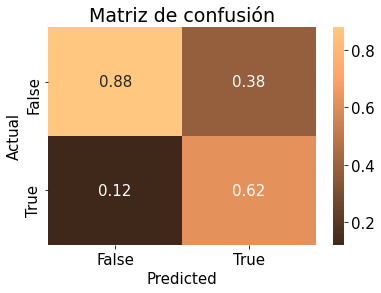

0.8185293456262649

In [35]:
calcular_estadisticas_desaturaciones(actual=test_y, predicted=predictions, savefig=False, threshold_desaturacion=3, accepted_error=1)

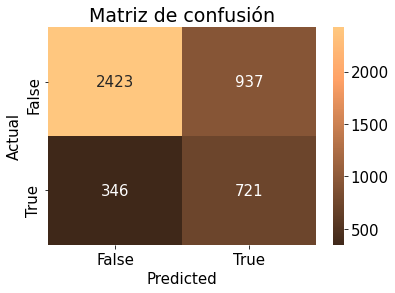

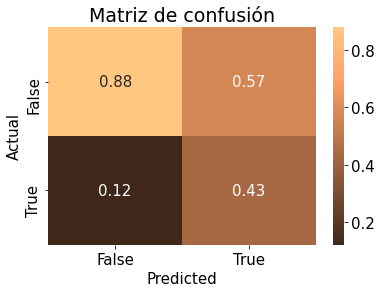

0.7101874858820872

In [36]:
path_modelo = "results_mlp/30_input/tmp_checkpoint_mlp_1500_32"
with open(os.path.join(path_modelo, "predicted_vs_real_no_smooth.pickle"), "rb") as handle:
    forward_predicted_list, forward_real_list = pickle.load(handle)

calcular_estadisticas_desaturaciones(actual=forward_real_list, predicted=forward_predicted_list, threshold_desaturacion = 3,accepted_error=1, savefig=True)

A la vista de los resultados, podemos ver como en el modelo de una salida, al eliminar el suavizado de la señal los resultados empeoran considerablemente. Por ello, podemos considerar mejor el modelo que genera múltiples salidas.

## Comparativa del RMSE una salida vs múltiples salidas

Es importante que para comparar el RMSE, se utilicen el mismo número de predicciones. Para ello, en los modelos que generan menos predicciones de las necesarias, se pueden realizar predicciones recursivas.

In [37]:
# Cargamos las predicciones recursivas del modelo de una salida
path_modelo = "results_mlp/30_input/tmp_checkpoint_mlp_1500_32"
with open(os.path.join(path_modelo, "predicted_vs_real.pickle"), "rb") as handle:
    forward_predicted_list, forward_real_list = pickle.load(handle)
score_one_output, scores_one_output = evaluate_forecasts(actual=forward_real_list, predicted=forward_predicted_list)

# Realizamos predicciones en el modelo de múltiples salidas
train, test, train_x, train_y, test_x, test_y, target_real, paciente = preparacion_datos(nombre_fichero="data_5.csv", train_size=0.8, smooth_seconds=6, seconds_prior=30, seconds_prediction=10, seconds_margin=1)
model_folder = "results_mlp/30_input_10_output/tmp_checkpoint_mlp_1000-500_64"
model = load_model(model_folder)
predictions = model.predict(test_x)
real = test_y
score_multi_output, scores_multi_output = evaluate_forecasts(actual=real, predicted=predictions)

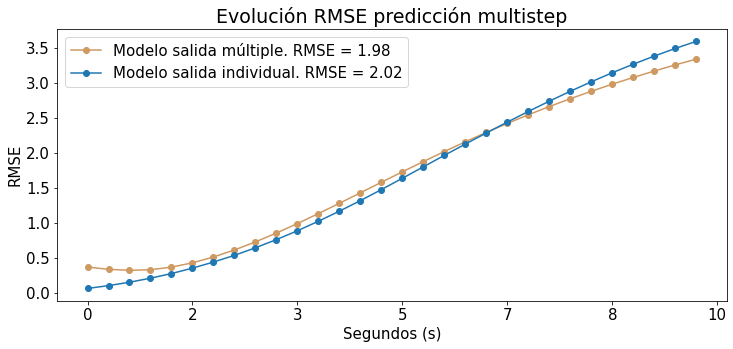

In [38]:
savefig = True
plt.figure(figsize=(12, 5))
plt.title("Evolución RMSE predicción multistep")
plt.plot(scores_multi_output, '-o', label=f"Modelo salida múltiple. RMSE = {score_multi_output:.2f}")
plt.plot(scores_one_output, '-o', label=f"Modelo salida individual. RMSE = {score_one_output:.2f}")
plt.xlabel("Segundos (s)")
plt.ylabel("RMSE")
plt.legend()
xticks_pos = [i for i in range(0, 35, 5)]
xticks_labels = [round(i/3) for i in xticks_pos]
plt.xticks(xticks_pos, xticks_labels)
if savefig: plt.savefig("rmse_multistep_prediction.pdf", transparent=True, bbox_inches = 'tight',pad_inches = 0.025)
plt.show()

## Comparativa del RMSE una salida vs múltiples salidas nuevo paciente

Una vez comprobados los resultados que hemos obtenido para este paciente, es interesante ver si los resultados se pueden extrapolar a otros pacientes. Para ello, vamos a cargar otro paciente y comprobar los resultados. En particular, nos interesa sobre aquellos pacientes con un IAH alto. En esta comparativa, incluimos tanto el resultado al suavizar la señal como al no suavizarla (nos interesa coger el modelo que tenga un mejor resultado sobre la señal sin suavizar).

In [39]:
model_folder = "results_mlp/30_input_10_output/tmp_checkpoint_mlp_1000-500_64"
model = load_model(model_folder)

In [40]:
# Leo los datos usando smooth
train, test, train_x, train_y, test_x, test_y, target_real, paciente = preparacion_datos(nombre_fichero="data_3.csv", train_size=0, smooth_seconds=6, seconds_prior=30, seconds_prediction=10, seconds_margin=1, drop_extremes_percentaje=0.1)
predictions = model.predict(test_x)
score_multi_output, scores_multi_output = evaluate_forecasts(actual=test_y, predicted=predictions)

#summarize_scores(score_multi_output, scores_multi_output)

# Miramos el RMSE del modelo de prediccion en un paso con smooth
path_modelo = "results_mlp/30_input/tmp_checkpoint_mlp_1500_32"
with open(os.path.join(path_modelo, "data_3_predicted_vs_real_smooth.pickle"), "rb") as handle:
    forward_predicted_list, forward_real_list = pickle.load(handle)

score_one_output, scores_one_output = evaluate_forecasts(actual=forward_real_list, predicted=forward_predicted_list)
# summarize_scores(score_one_output, scores_one_output)

# Desactivamos el smooth
train, test, train_x, train_y, test_x, test_y, target_real, paciente = preparacion_datos(nombre_fichero="data_3.csv", train_size=0, smooth_seconds=0, seconds_prior=30, seconds_prediction=10, seconds_margin=1, drop_extremes_percentaje=0.1)
predictions = model.predict(test_x)
score_multi_output_no_smooth, scores_multi_output_no_smooth = evaluate_forecasts(actual=test_y, predicted=predictions)

# Miramos el RMSE del modelo de prediccion en un paso sin smooth
with open(os.path.join(path_modelo, "data_3_predicted_vs_real_no_smooth.pickle"), "rb") as handle:
    forward_predicted_list, forward_real_list = pickle.load(handle)

score_one_output_no_smooth, scores_one_output_no_smooth = evaluate_forecasts(actual=forward_real_list, predicted=forward_predicted_list)

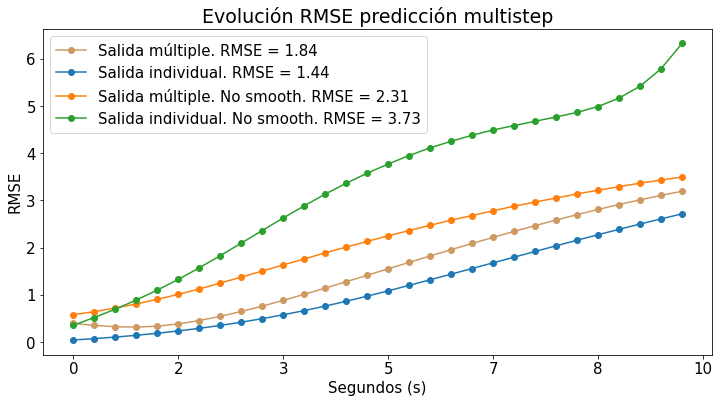

In [41]:
savefig = True
plt.figure(figsize=(12, 6))
plt.title("Evolución RMSE predicción multistep")
plt.plot(scores_multi_output, '-o', label=f"Salida múltiple. RMSE = {score_multi_output:.2f}")
plt.plot(scores_one_output, '-o', label=f"Salida individual. RMSE = {score_one_output:.2f}")

plt.plot(scores_multi_output_no_smooth, '-o', label=f"Salida múltiple. No smooth. RMSE = {score_multi_output_no_smooth:.2f}")
plt.plot(scores_one_output_no_smooth, '-o', label=f"Salida individual. No smooth. RMSE = {score_one_output_no_smooth:.2f}")

plt.xlabel("Segundos (s)")
plt.ylabel("RMSE")
plt.legend()
xticks_pos = [i for i in range(0, 35, 5)]
xticks_labels = [round(i/3) for i in xticks_pos]
plt.xticks(xticks_pos, xticks_labels)
if savefig: plt.savefig("rmse_multistep_prediction_other_patient.pdf", transparent=True, bbox_inches = 'tight',pad_inches = 0.025)
plt.show()

## Matriz confusión evaluación sobre nuevo paciente

A continuación, vamos a evaluar las predicciones de eventos de desaturación que realiza el modelo al utilizarlo sobre un paciente nuevo desconocido para el modelo.

### Utilizando el modelo de salidas múltiples

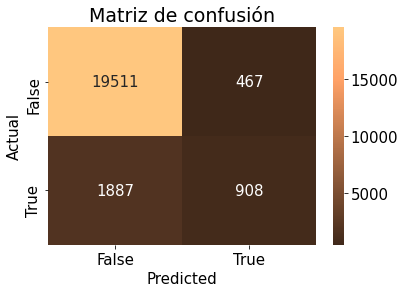

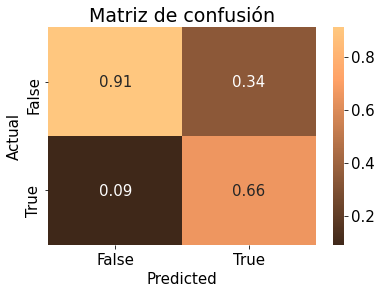

0.8966319764633557

In [42]:
model_folder = "results_mlp/30_input_10_output/tmp_checkpoint_mlp_1000-500_64"
model = load_model(model_folder)
train, test, train_x, train_y, test_x, test_y, target_real, paciente = preparacion_datos(nombre_fichero="data_3.csv", train_size=0, smooth_seconds=6, seconds_prior=30, seconds_prediction=10, seconds_margin=1, drop_extremes_percentaje=0.1)

predictions = model.predict(test_x)

calcular_estadisticas_desaturaciones(actual=test_y, predicted=predictions, threshold_desaturacion = 3, savefig=True, accepted_error=1)

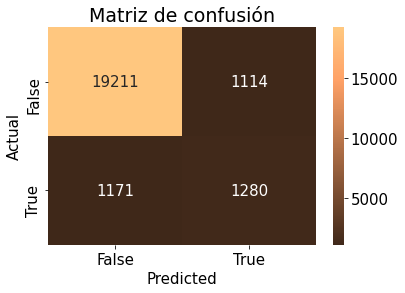

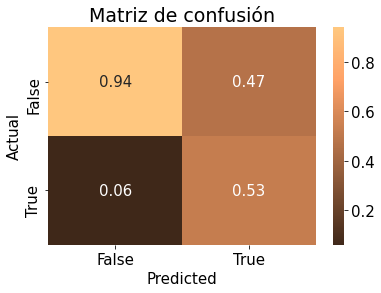

0.8996750965929048

In [43]:
train, test, train_x, train_y, test_x, test_y, target_real, paciente = preparacion_datos(nombre_fichero="data_3.csv", train_size=0, smooth_seconds=0, seconds_prior=30, seconds_prediction=10, seconds_margin=1, drop_extremes_percentaje=0.1)

predictions = model.predict(test_x)

calcular_estadisticas_desaturaciones(actual=test_y, predicted=predictions, threshold_desaturacion = 3, savefig=True, accepted_error=1)

### Utilizando el modelo de una salida

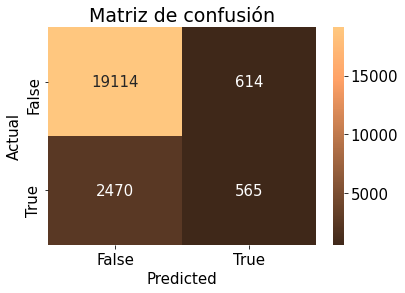

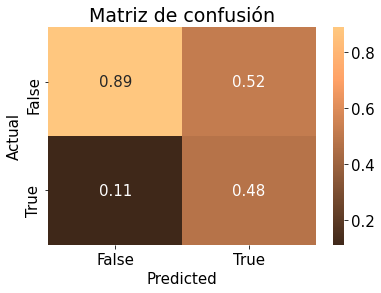

0.864516979308527

In [45]:
# Miramos el RMSE del modelo de prediccion en un paso
path_modelo = "results_mlp/30_input/tmp_checkpoint_mlp_1500_32"
with open(os.path.join(path_modelo, "data_3_predicted_vs_real_smooth.pickle"), "rb") as handle:
    forward_predicted_list, forward_real_list = pickle.load(handle)
calcular_estadisticas_desaturaciones(actual=forward_real_list, predicted=forward_predicted_list, threshold_desaturacion = 3, savefig=False, accepted_error=1)

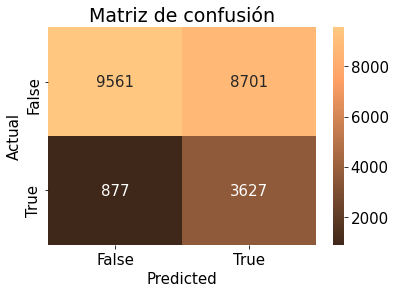

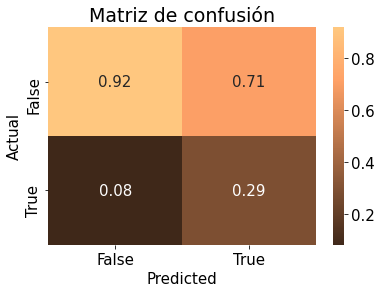

0.5792848985328999

In [46]:
path_modelo = "results_mlp/30_input/tmp_checkpoint_mlp_1500_32"
with open(os.path.join(path_modelo, "data_3_predicted_vs_real_no_smooth.pickle"), "rb") as handle:
    forward_predicted_list, forward_real_list = pickle.load(handle)

calcular_estadisticas_desaturaciones(actual=forward_real_list, predicted=forward_predicted_list, threshold_desaturacion = 3,accepted_error=1, savefig=True)